In [1]:
# %pip install numpy==1.26.4
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
# POINT TO THE FOLDER WHERE YOU STORE THE RESULTS
results_path = './results/'

#all models we have - don't change
all_models = ['KNN','GNB','RF','XGB','Baseline']

#Select the models  you want to load for visualizations - make sure the relevant files are there. 
#You could default to all models but we will use RF, XGB and Baseline for this example
# models=all_models
models = ['RF','XGB','Baseline']


#test_version (File naming schemes) - this identifies the results file. USE THE SAME ONE YOU USED IN THE CV TRAINING NOTEBOOK
test_version = 'final_version' 
# test_version = 'test1-full'
# test_version = 'test-full-5-runs'
# test_version = 'test-imaging-full-5-runs'
# test_version = 'test-age-filter-imaging-full-5-runs'
# test_version = 'new-age-filter-imaging-full-5-runs'

## Some function definitions

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
from IPython.display import display

# !jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --user --py widgetsnbextension

#corresponding names and colors - don't change without understanding what these correspond to
model_names={'KNN':'K-Nearest Neighbor','GNB':'Gaussian Naive Bayes','DT': 'Decision Tree','RF': 'Random Forest','XGB':'XGBoost','SVC':'Support Vector Classifier','LR':'Logistic Regression','Baseline': 'Baseline'}
m_colors={'Baseline':'#003f5c','RF':'#7a5195','GNB':'#ef5675','KNN':'#ffa600','DT':'#F4D4D4','XGB':'#34ebe1','SVC':'#39d624', 'LR': '#fc1c03'}
t_colors = {30:'#488f31',60:'#bab874',90:'#feebd4',120:'#eb9d7b',180:'#de425b',3000:'#bb29b9'}
action_name_dictionary={} #In case you want to replace feature names in the feature importance chart with other names you can use this dictionary to map feature 

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:

def plot_feature_importance(importances,model_type):

	#Create arrays from feature importance and feature names
	feature_importance = np.array(importances['importance'])
	feature_names = np.array(importances.index)

	feature_names = [action_name_dictionary[x] if x in action_name_dictionary else x for x in feature_names]

	#Create a DataFrame using a Dictionary
	data={'feature_names':feature_names,'feature_importance':feature_importance}
	fi_df = pd.DataFrame(data)

	#Sort the DataFrame in order decreasing feature importance
	fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

	#Define size of bar plot
	plt.figure(figsize=(10,8))
	#Plot Searborn bar chart
	sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
	#Add chart labels
	plt.title(model_type + ' Feature Importances')
	plt.xlabel('FEATURE IMPORTANCE')
	plt.ylabel('FEATURE NAMES')

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
def prediction_meanings(matrices,name='Total Admitted'):
#     if name == 'Death':
#         labels = ['Death','No Death']
#     elif name == 'Hospitalizations':
#         labels = ['Hospitalization','No Hospitalization']
#     elif name =='Risk':
#         labels = ['High Risk','Low Risk']
    labels = ['Admission', 'No Admission']

    #average prediction results over all folds
    matrix = np.mean(matrices,axis=0)
    
    #convert to percentages
    m= matrix*100/matrix.sum()
    
    #plot the matrix
    fig, ax = plt.subplots(1,1,figsize=(6,4))
#     plt.figure(figsize=(3,2))
    disp=ConfusionMatrixDisplay(np.flip(np.transpose(m)),display_labels=labels)
    disp.plot(values_format='.1f',ax=ax)
    ax.set_xlabel("True Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

In [6]:
def regression_roc_auc_score(y_true, y_pred, num_rounds = 'exact'):
#   """
#   Computes Regression-ROC-AUC-score.
  
#   Parameters:
#   ----------
#   y_true: array-like of shape (n_samples,). Binary or continuous target variable.
#   y_pred: array-like of shape (n_samples,). Target scores.
#   num_rounds: int or string. If integer, number of random pairs of observations. 
#               If string, 'exact', all possible pairs of observations will be evaluated.
  
#   Returns:
#   -------
#   rroc: float. Regression-ROC-AUC-score.
#   """
  
#   import numpy as np
    
#   y_true = np.array(y_true)
#   y_pred = np.array(y_pred)

    num_pairs = 0
    num_same_sign = 0
#     print(y_true)
  
#     print('yield pairs')
#     for x in _yield_pairs(y_true, num_rounds):
#         print (x)
    for i, j in _yield_pairs(y_true, num_rounds):
#         print('i',i)
#         print('j',j)
#         print('y_true i',y_true[i])
#         print('y_true j',y_true[j])

        diff_true = y_true[i] - y_true[j]
        diff_score = y_pred[i] - y_pred[j]
        if diff_true * diff_score > 0:
          num_same_sign += 1
        elif diff_score == 0:
          num_same_sign += .5
        num_pairs += 1

    return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
    """
    Returns pairs of valid indices. Indices must belong to observations having different values.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,). Binary or continuous target variable.
    num_rounds: int or string. If integer, number of random pairs of observations to return. 
              If string, 'exact', all possible pairs of observations will be returned.

    Yields:
    -------
    i, j: tuple of int of shape (2,). Indices referred to a pair of samples.

    """
#   import numpy as np
    if num_rounds == 'exact':
        for i in range(len(y_true)):
            for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
                yield i, j     
    else:
        for r in range(num_rounds):
            i = np.random.choice(range(len(y_true)))
            j = np.random.choice(np.where(y_true != y_true[i])[0])
            yield i, j



from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
def output_metrics(outs):
#     average_matrix=np.mean(matrices,axis=0)
    r2s = []
    maes=[]
    rmses=[]
    aucs=[]
    for out in outs[:-1]:
        r2 = r2_score(out[0],out[1])
        r2s.append(r2)
        mae = mean_absolute_error(out[0],out[1])
        maes.append(mae)
        mse = mean_squared_error(out[0],out[1])
        rmses.append(np.sqrt(mse))
        auc = regression_roc_auc_score(out[0],out[1])
        aucs.append(auc)
    r2=np.mean(r2s)
    mae=np.mean(maes)
    rmse=np.mean(rmses)
    auc=np.mean(aucs)
    print("r2 :",r2)
    print('mae:',mae)
    print('rmse:',rmse)
    print('auc:',auc)
    print('Feature Importance',outs[-1].head(10))
    return([outs,r2s,maes,rmses,aucs])

In [7]:
def comparisons():

    plt.rcParams["figure.figsize"] = (30,14)
    fig, ax = plt.subplots()

    name = 'Admissions'
    labels = ['Acc_Overall','Acc_No_Admission', 'Acc_Admission']
    tg=time_graphs1
    
        
    x = np.arange(len(labels)) #the label locations
    width = 0.16  #the width of the bars

    #plot the bars
    rects = []
    for i in range(len(models)):
        model = models[i]
        pos = i - len(models)/2
#         rects.append(ax.bar(x + pos*width, [*tg[model][0][-3:],tg[model][-1]], width, label=model_names[model],color=m_colors[model]))
        rects.append(ax.bar(x + pos*width, [*tg[model][0][-3:]], width, label=model_names[model],color=m_colors[model]))

    # to provide numbered labels on top of figure
    for rect in rects:
        for r in rect:
            height = r.get_height()
            ax.annotate('{:.3f}'.format(height),
                        xy=(r.get_x() + r.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=21)


    # Add some text for labels, title and custom x-axis tick labels, etc. and plot the graph
    ax.set_ylabel('Percentage Accuracies',fontsize=44)
    ax.set_title('Predicting '+name,fontsize=44)
    ax.set_xticks(x)
    ax.set_xticklabels(labels,fontsize=36)
    ax.legend(fontsize=20,loc='upper right')
    plt.yticks(fontsize=34)
    plt.xticks(fontsize=34)
    ax.set_ylim([0,110])
    plt.grid(which='both',axis='y',color='gray', linestyle='--', linewidth=.5)
    plt.minorticks_on()
    return(fig,ax)

# Visualizations for Predictive Models for Hospital Admissions

## Predictive Models for Admissions - Load Models

In [8]:
#loads up models into dictionary
time_graphs1={}

for model in models:
    with open(results_path+model+'_'+test_version+'.pkl', 'rb') as file:
        time_graphs1[model] = pd.read_pickle(file)



## Predictive Models for Admissions - Plot comparisons between models and comparisons over time

(<Figure size 3000x1400 with 1 Axes>,
 <Axes: title={'center': 'Predicting Admissions'}, ylabel='Percentage Accuracies'>)

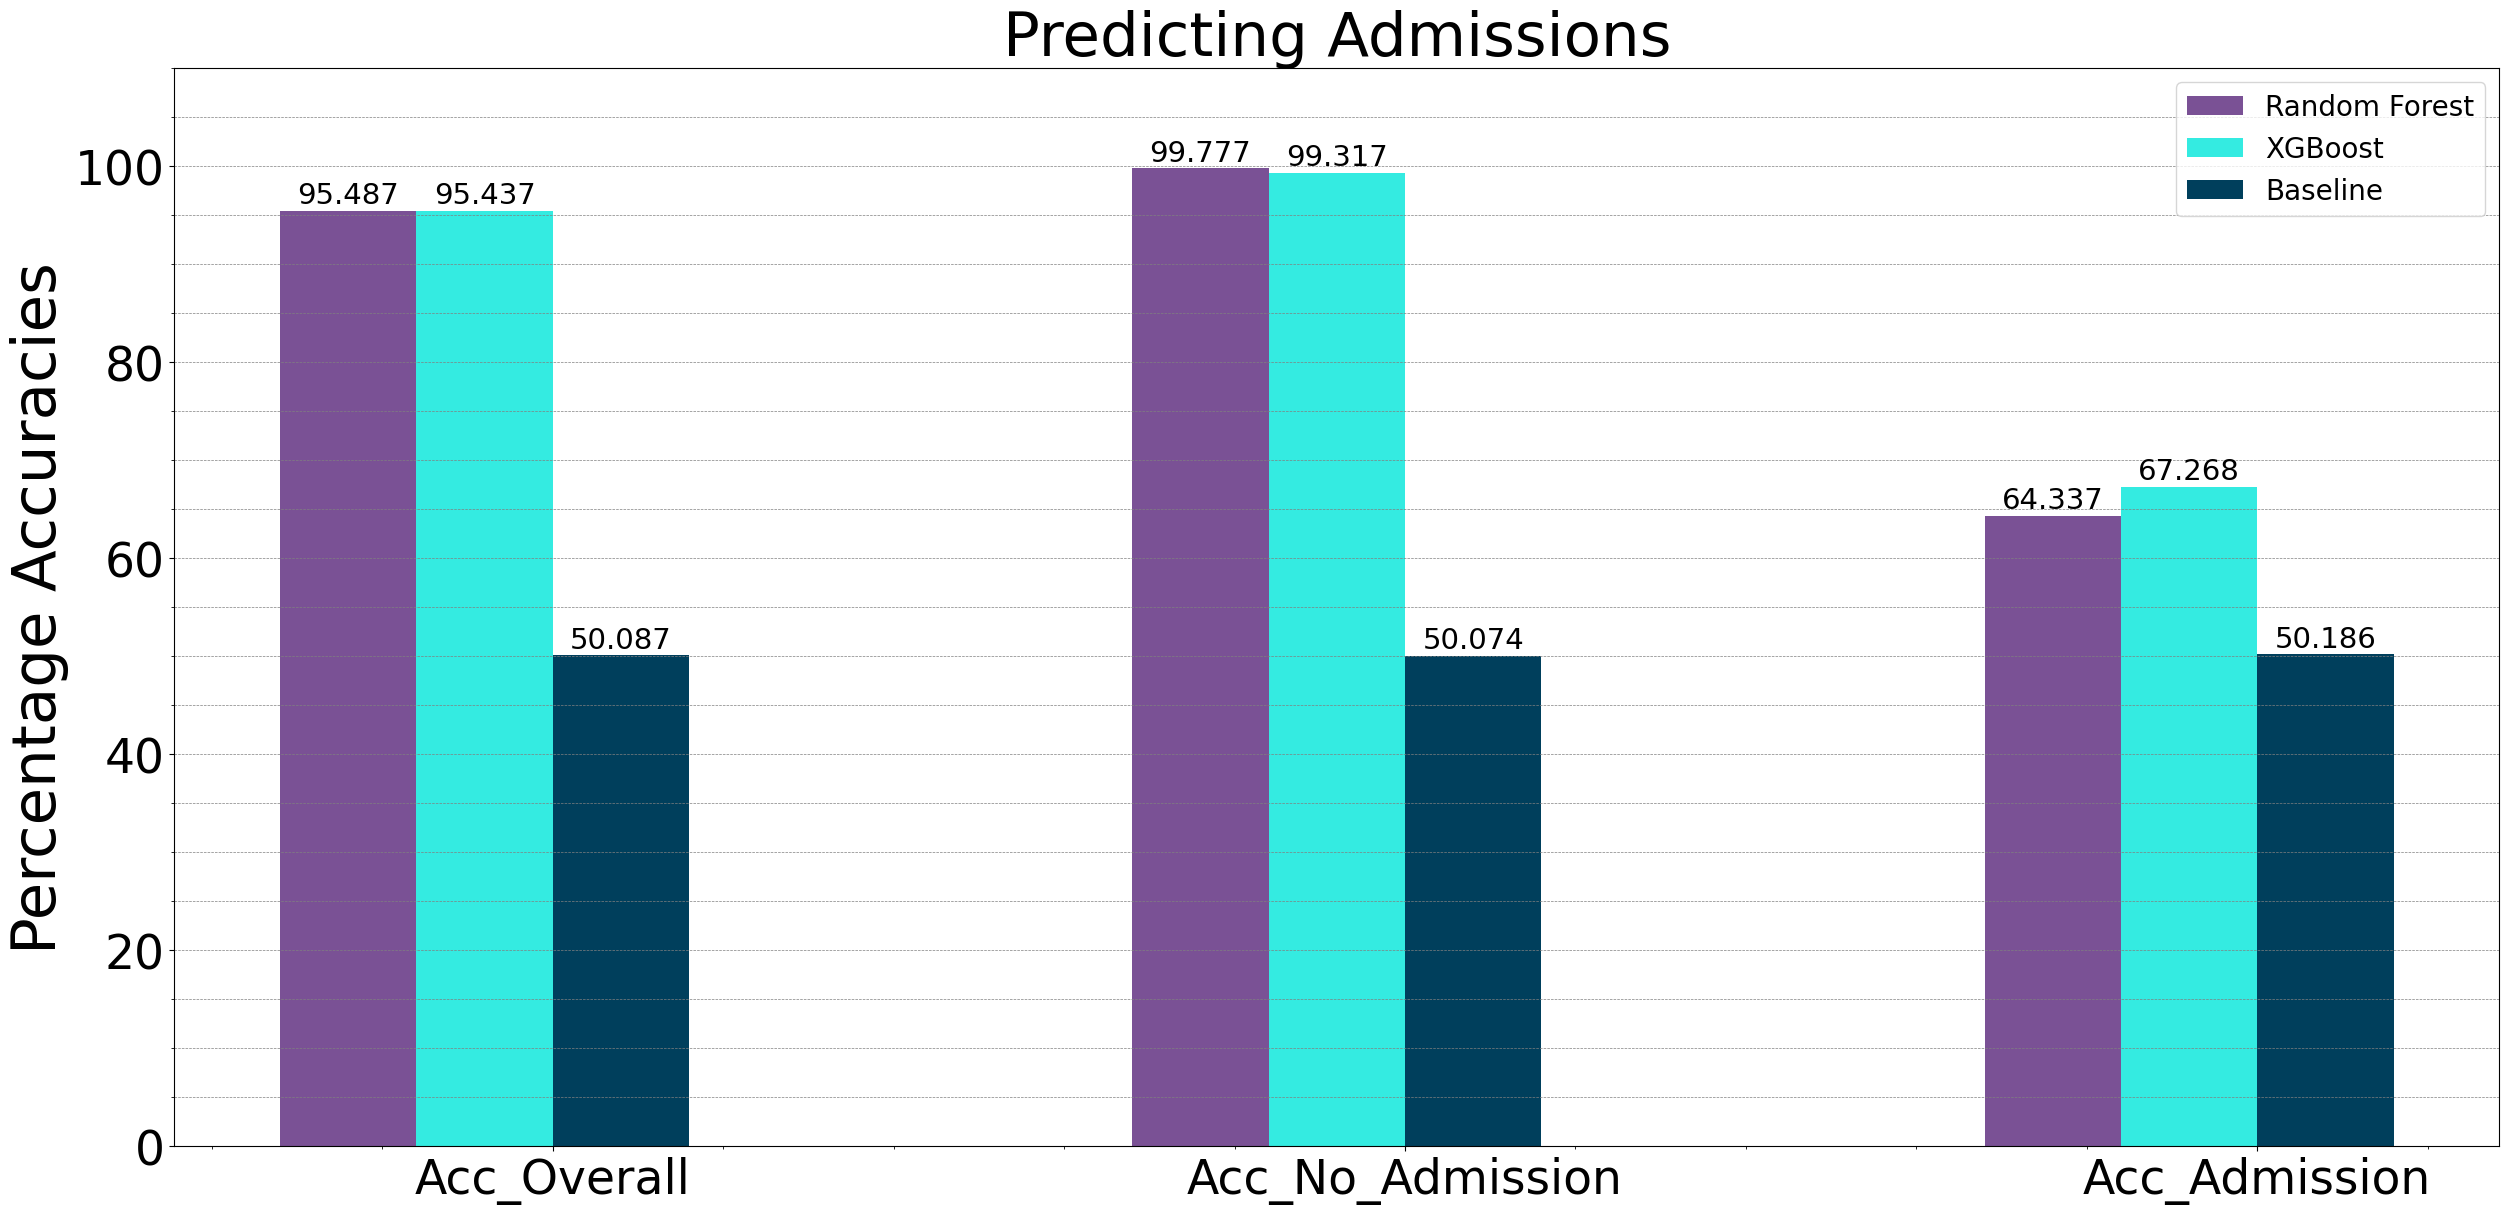

In [9]:
comparisons()

# Display AUCS

In [10]:
from tabulate import tabulate
auc_table = []
headers = ['Model','AUC']
for i in range(len(models)):
    model = models[i]
#     print("AUC for ", model, " : ", time_graphs1[model][-1])
    auc_table.append([model,float(time_graphs1[model][-1])])
    

table = tabulate(auc_table, floatfmt='.3f',headers=headers)
print(table)


Model       AUC
--------  -----
RF        0.821
XGB       0.833
Baseline  0.501


## Predictive Models for Hospital Admissions - Feature Importances

In [11]:
#choose which model you want feature importances for
model_to_see_dropdown = widgets.Dropdown(options=models, value = models[0], description='Model: ', disabled = False)
display(model_to_see_dropdown)

Dropdown(description='Model: ', options=('RF', 'XGB', 'Baseline'), value='RF')

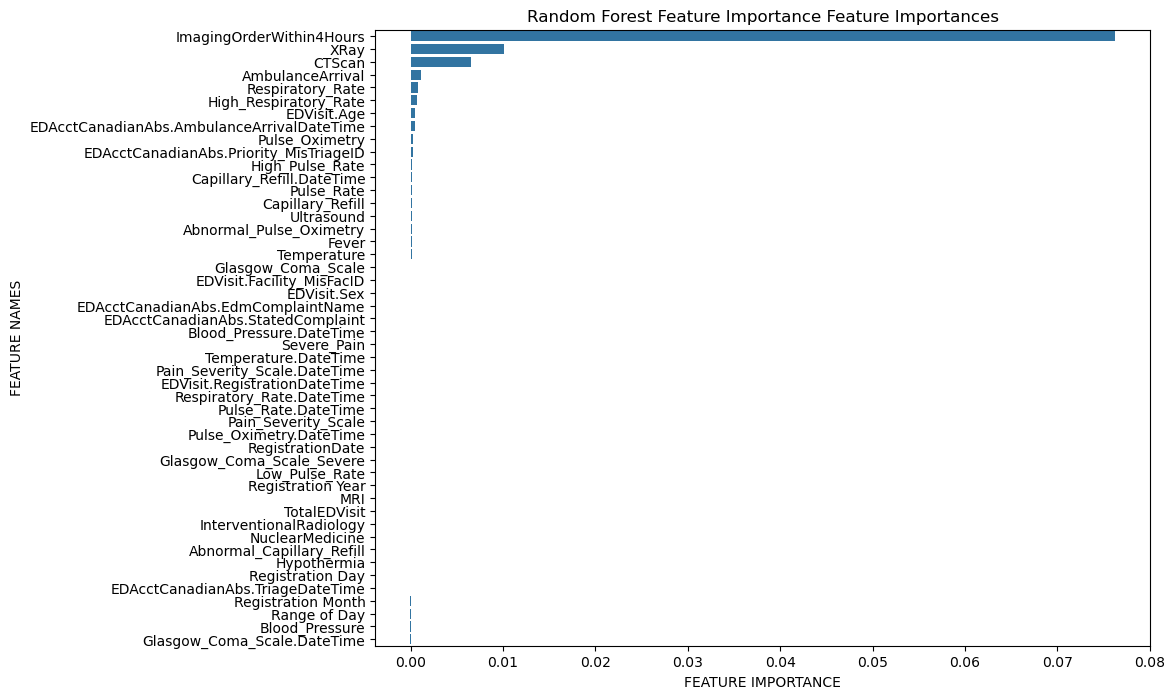

In [12]:
#AFTER SELECTING THE VALUE IN THE DROPDOWN - Run this cell. If you re-run the dropdown cell it will default to the first value
model_to_see = model_to_see_dropdown.value

plot_feature_importance(time_graphs1[model_to_see][0][1],model_names[model_to_see]+' Feature Importance')

## Predictive Models for Hospital Admissions - Confusion Matrix for a Model

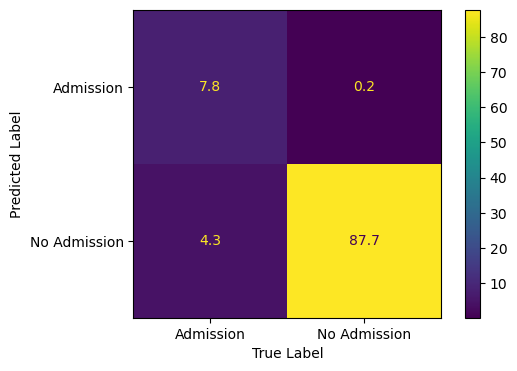

In [13]:
#choose which model you want feature importances for
model_to_see = model_to_see_dropdown.value

prediction_meanings(time_graphs1[model_to_see][0][0][:-1])

###### 